DIABETES PREDICTION


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import zscore
from scipy.stats import probplot
from xgboost import XGBClassifier
import math

READ DATASET

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
df.sample(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
59928,Female,22.0,0,0,No Info,22.03,6.2,160,0
13256,Male,25.0,0,0,former,35.81,4.5,145,0
99397,Female,40.0,0,0,never,32.10,4.0,90,0
57640,Male,25.0,0,0,never,38.63,6.2,130,0
87403,Female,44.0,0,0,never,30.22,6.0,200,0


Gender is not necessary lets drop it

In [4]:
df = df.drop('gender', axis=1)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  100000 non-null  float64
 1   hypertension         100000 non-null  int64  
 2   heart_disease        100000 non-null  int64  
 3   smoking_history      100000 non-null  object 
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.1+ MB
None


Check for missing values

In [6]:
df.isnull().sum()

,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


Check duplicates

In [7]:
df.duplicated().sum()

6389

In [8]:
df = df.drop_duplicates()
df.shape[0]

93611

In [9]:
df.replaceo Info'('N, float('nan'), inplace=True)

Correlation Matrix

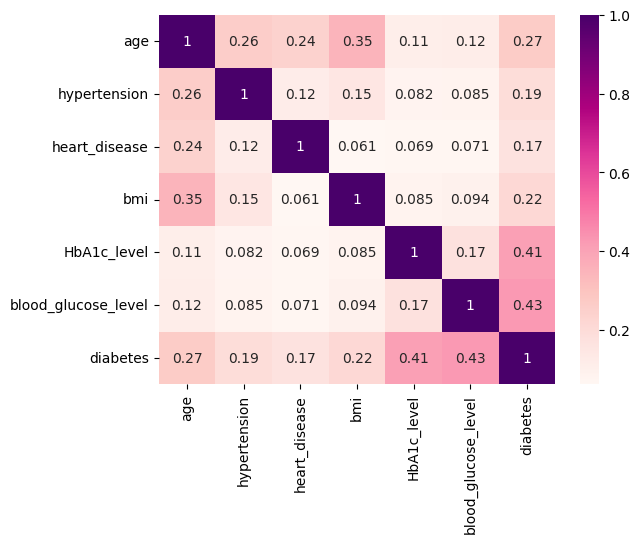

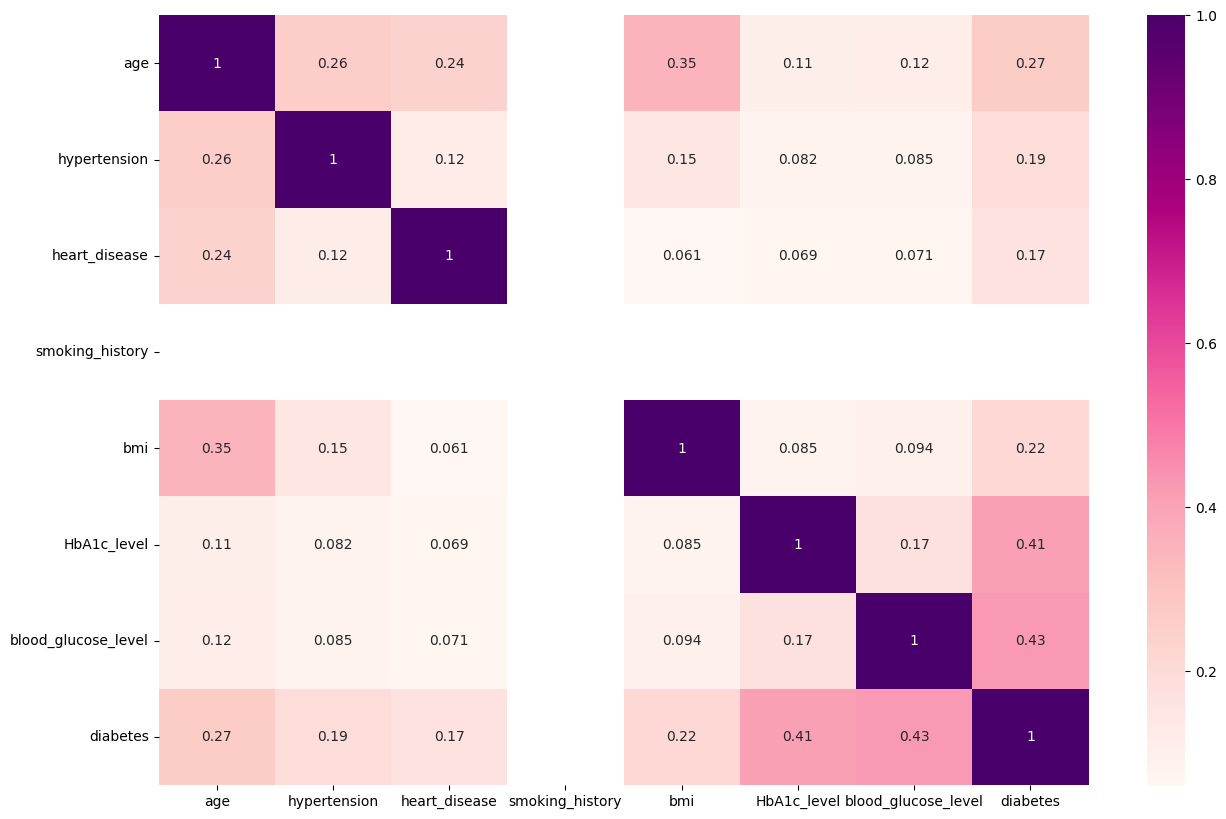

In [10]:
import seaborn as sns
non_numeric_columns = df.select_dtypes(include=['object']).columns
df_numeric = df.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(), annot=True, cmap='RdPu')
df['smoking_history'] = df['smoking_history'].map({'never': 0, 'sometimes': 1, 'always': 2})
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdPu')
plt.show()




Data Visualization

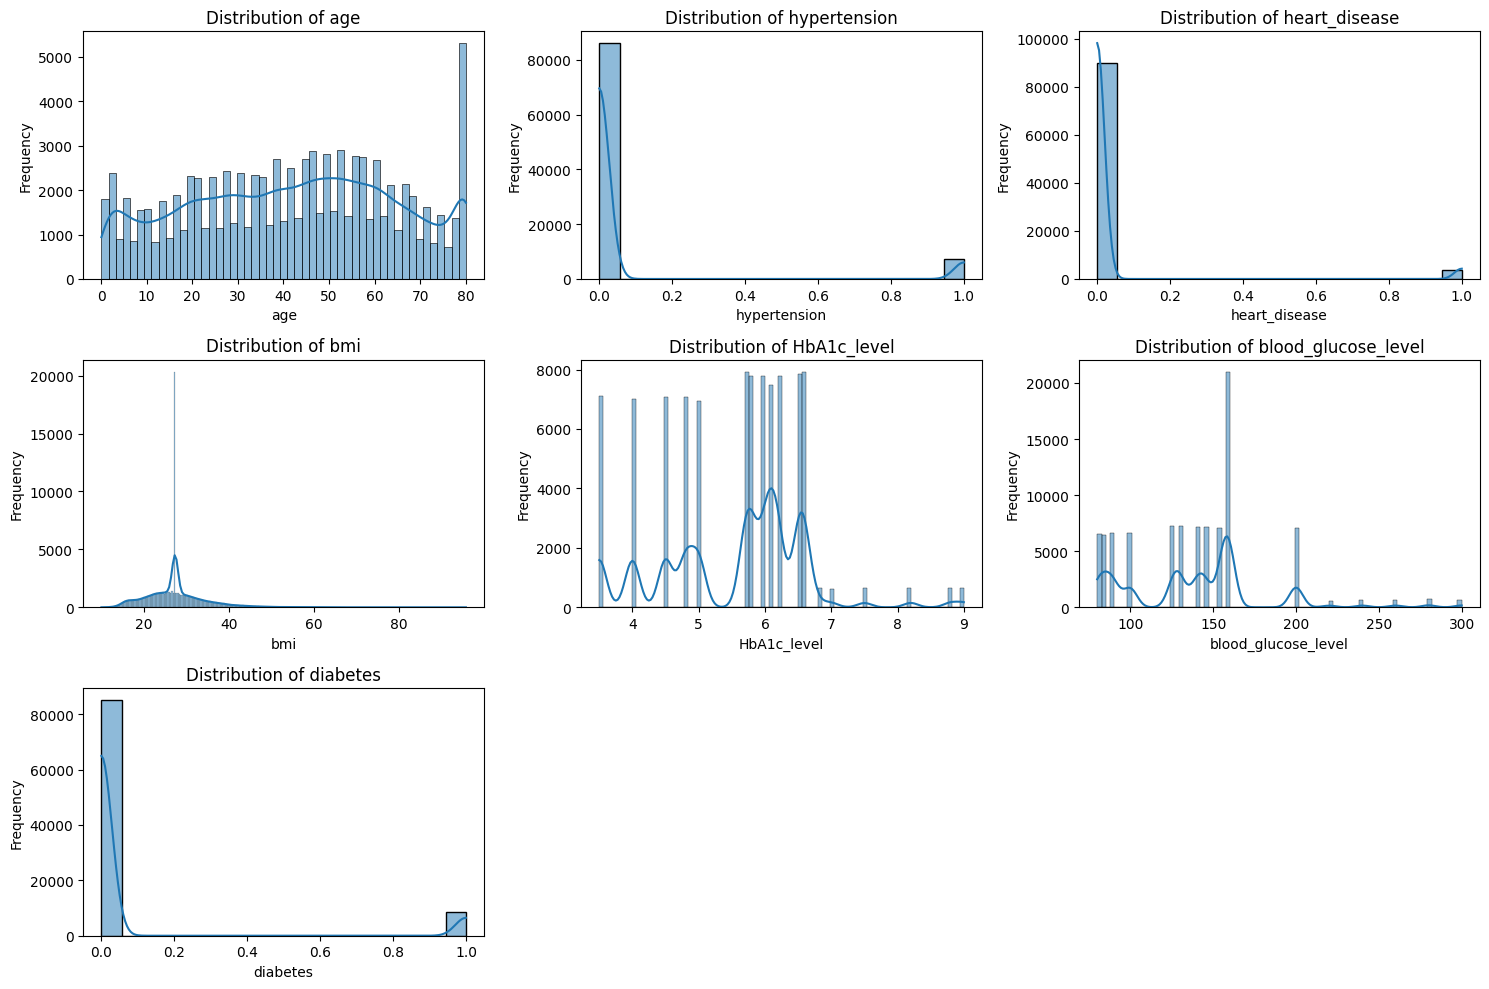

In [11]:
# Distribution plots for each numeric feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_numeric, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

One hot encoding

In [12]:
print(df['smoking_history'].unique())

[ 0. nan]


In [13]:
categorical_cols = ['smoking_history']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,93611.0,41.833746,22.485157,0.08,24.00,43.00,60.000,80.00
hypertension,93611.0,0.079606,0.270684,0.00,0.00,0.00,0.000,1.00
heart_disease,93611.0,0.041747,0.200012,0.00,0.00,0.00,0.000,1.00
bmi,93611.0,27.322993,6.857632,10.01,23.24,27.32,30.035,95.69
HbA1c_level,93611.0,5.536296,1.075454,3.50,4.80,5.80,6.200,9.00
blood_glucose_level,93611.0,138.331670,41.052424,80.00,100.00,140.00,159.000,300.00
diabetes,93611.0,0.090481,0.286871,0.00,0.00,0.00,0.000,1.00


Check for Class Imbalance and sampling

In [15]:
x = df.drop('diabetes', axis=1)
y = df['diabetes']

In [16]:
target_distribution = y.value_counts(normalize=True) * 100

# Print the percentage distribution
target_distribution

,proportion
diabetes,
0,90.951918
1,9.048082


In [17]:
# Assuming 'diabetes' is the target column
target_frequency = df['diabetes'].value_counts()

print(target_frequency)


diabetes
0    85141
1     8470
Name: count, dtype: int64


Handling imbalance dataset by applying SMOTE

In [18]:
# by applying SMOTE

from imblearn.over_sampling import SMOTE

# Example: Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

In [19]:
target_distribution = y_resampled.value_counts(normalize=True) * 100

# Print the percentage distribution
target_distribution

,proportion
diabetes,
0,50.0
1,50.0


Removing Outlier using Z-score

In [20]:
X_resampled.sample(5)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
76043,25.000000,0,0,23.990000,6.2,145
124220,67.503577,0,0,36.643126,9.0,280
17314,15.000000,0,0,22.250000,6.2,159
82948,67.000000,0,0,27.000000,3.5,159
51552,22.000000,0,0,29.890000,4.0,159


In [21]:
df = pd.concat([X_resampled, y_resampled], axis=1)


In [22]:
numerical_cols = ['age','bmi','HbA1c_level','blood_glucose_level']

z_scores = zscore(df[numerical_cols])

# Set a threshold for outlier detection (e.g., 3 standard deviations)
threshold = 4

# Identify and remove outliers
outliers_mask = (abs(z_scores) > threshold).any(axis=1)
df = df[~outliers_mask]
row=df.shape[0]
print(row)
df=df.dropna()
row=df.shape[0]
row

169822


169822

Slipt Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Training Models


Linear Regression

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, lr_predictions)
mae = mean_absolute_error(y_test, lr_predictions)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")
print(f"Linear Regression Mean Absolute Error: {mae:.2f}")

Linear Regression Mean Squared Error: 0.10
Linear Regression Mean Absolute Error: 0.27


KNN

In [25]:
# Create a pipeline with the KNN classifier
knn_pipeline = make_pipeline(KNeighborsClassifier())

# Define the parameter grid for GridSearchCV
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],  # You can add more values to test
    'kneighborsclassifier__weights': ['uniform', 'distance'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train,y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Predict on the test set using the best estimator
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Best Parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Model Accuracy: 0.9449746014035294
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94     16947
           1       0.93      0.97      0.95     17110

    accuracy                           0.94     34057
   macro avg       0.95      0.94      0.94     34057
weighted avg       0.95      0.94      0.94     34057



Decision Tree

In [26]:
# Best Parameters for Decision Tree Classifier
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create and train the Decision Tree Classifier with the specified parameters
dt_classifier = DecisionTreeClassifier(criterion=best_params['criterion'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       random_state=0)

dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Classification Report:\n", report_dt)

Decision Tree Model Accuracy: 0.9728102886337611
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     16947
           1       0.98      0.97      0.97     17110

    accuracy                           0.97     34057
   macro avg       0.97      0.97      0.97     34057
weighted avg       0.97      0.97      0.97     34057



Random forest classifier

In [27]:
# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=100, max_depth=10)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Model Accuracy: 0.9253017000910239
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     16947
           1       0.91      0.95      0.93     17110

    accuracy                           0.93     34057
   macro avg       0.93      0.93      0.93     34057
weighted avg       0.93      0.93      0.93     34057



AdaBoost Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
# Set 'diabetes' as the target variable (replace 'target' with 'diabetes')
X = df.drop('diabetes', axis=1)  # Features (drop the target column)
y = df['diabetes']  # Target variable (diabetes column)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the best parameters for the Decision Tree Classifier (although it's not needed anymore)
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create and train the Decision Tree Classifier with the specified parameters
dt_classifier = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=0
)

# Create and train the AdaBoost Classifier (no need for base_estimator anymore)
ada_classifier = AdaBoostClassifier(n_estimators=50, random_state=0)

# Train the AdaBoost model
ada_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_test = ada_classifier.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display only the test accuracy in the format: accuracy: 0.96
print(f"accuracy: {test_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


accuracy: 0.96
